### This file consists of the clustering of the dataset. This code covers three sets of clustering, Kmeans, DBSCAN and Hierarchical Clustering

In [49]:
# Import all the libraries
import pandas as pd
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from wordcloud import WordCloud
import numpy as np
import hdbscan
import pickle
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
import os
import re

In [4]:
# Load the merged dataset
final_data = pd.read_csv("../data/final_dataset.csv")

### In this section I have extracted the features using the TF-IDF verctorizer from the dataset and also performed dimensionality redcution using PCA for visualization

In [6]:
# Combine Question_Body and Answer_Body for clustering
final_data['Text'] = final_data['QuestionText'].astype(str) + " " + final_data['AnswerText'].astype(str)

# Tokenize text data
final_data['Tokenized_Text'] = final_data['Text'].apply(lambda x: x.split())

# Train Word2Vec model
print("Training Word2Vec model...")
word2vec_model = Word2Vec(sentences=final_data['Tokenized_Text'], vector_size=100, window=5, min_count=1, workers=4)
print("Word2Vec training completed.")

# Convert text to vectors using Word2Vec
def text_to_vector(tokens, model):
    """
    Converts a list of tokens to a vector by averaging the Word2Vec embeddings of the tokens.
    """
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

print("Converting text to vectors...")
final_data['Vector'] = final_data['Tokenized_Text'].apply(lambda x: text_to_vector(x, word2vec_model))
vectors = np.stack(final_data['Vector'].values)

# Dimensionality Reduction for Visualization
print("Reducing dimensions with PCA...")
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(vectors)
print(f"PCA reduced dimensions to {reduced_features.shape[1]}.")

Training Word2Vec model...
Word2Vec training completed.
Converting text to vectors...
Reducing dimensions with PCA...
PCA reduced dimensions to 2.


### KMeans Clustering

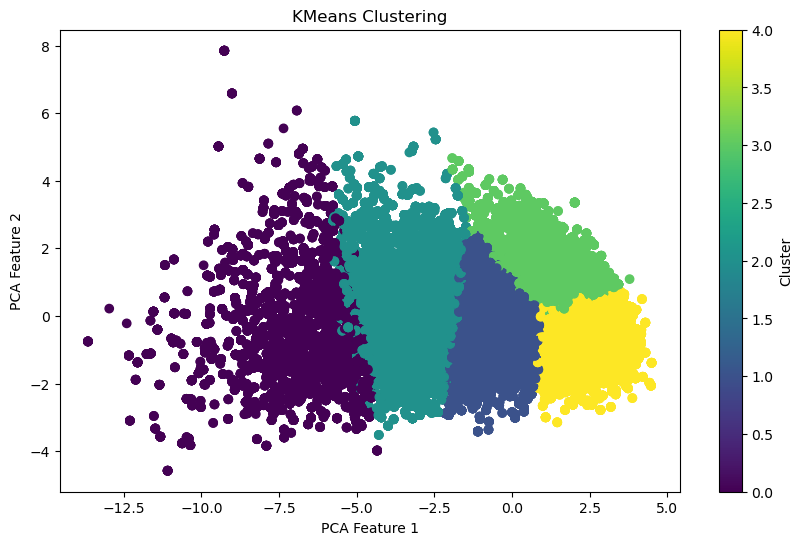

In [8]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(vectors)

# Visulize the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("KMeans Clustering")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.colorbar(label="Cluster")
plt.show()

### Wordcloud for KMeans

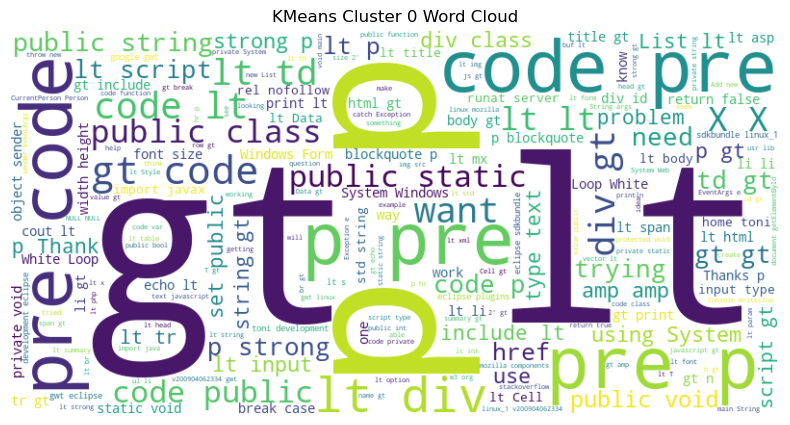

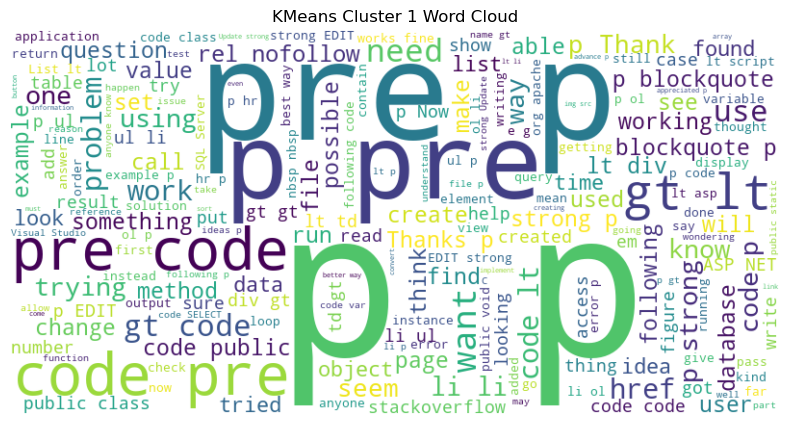

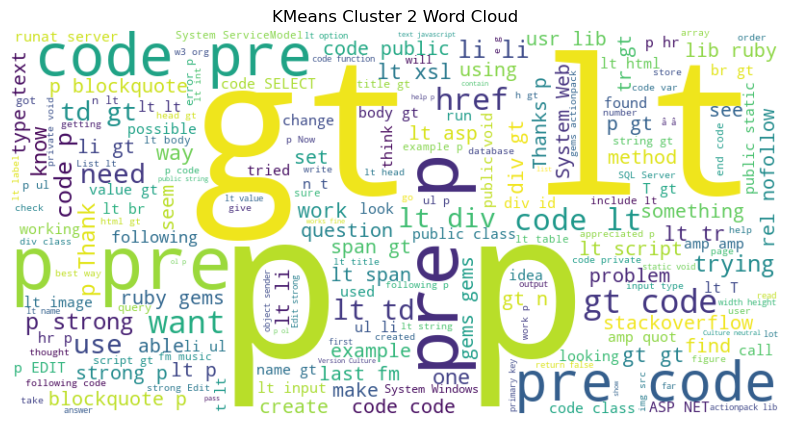

In [13]:
for cluster in range(3):
    cluster_data = final_data[kmeans_labels == cluster]
    text = " ".join(cluster_data["QuestionText"].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"KMeans Cluster {cluster} Word Cloud")
    plt.show()

### Meaning of the Word Clouds

As we can see from the above word clouds that were generated from the clusters createdby the Kmeans algorithm, if we take the word clodu for cluster 0 we can see that the words are mainly (code, pre, li, p, ul, href and ref)

#### Technical Tags
If we look at the technical tags for these it is clearn tat these are likely HTML related tags or web development. 

#### Programming related terms (href, rel, stackoverflow)
These terms suggest that the cluster involves questions related to hyperlinks or how to implement links in the web context.

#### Action Oriented Terms
These indicate that the nature of questions mainly involves troubleshoooting or asking help with coding problems.

From the dominence of HTML related terms it is highly likely that cluster 0 mainly deals with Web Development based questions.

### DBSCAN

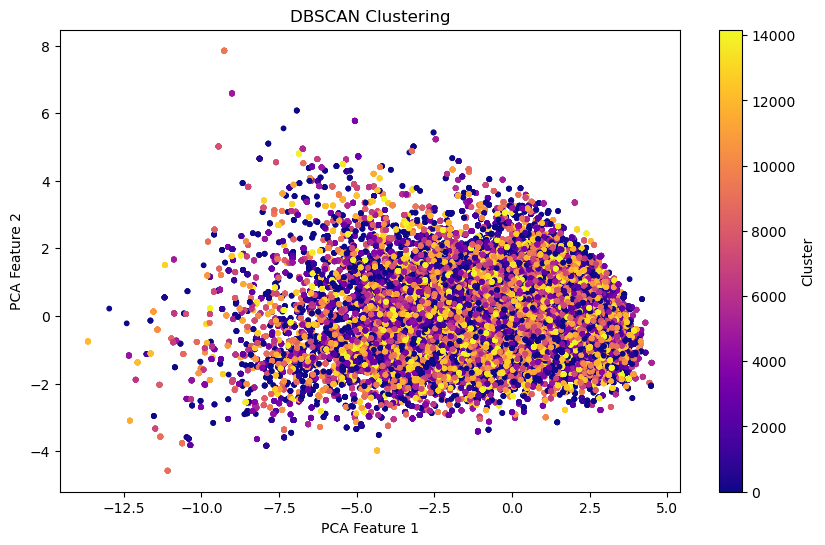

In [17]:
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan_labels = dbscan.fit_predict(vectors)

# Visualize DBSCAN Clustering
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=dbscan_labels, cmap='plasma', s=10)
plt.title("DBSCAN Clustering")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.colorbar(label="Cluster")
plt.show()

Generating Word Clouds for DBSCAN Clusters...


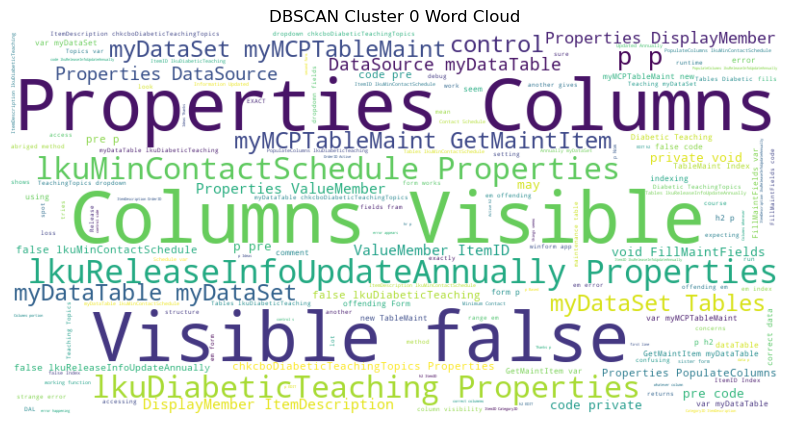

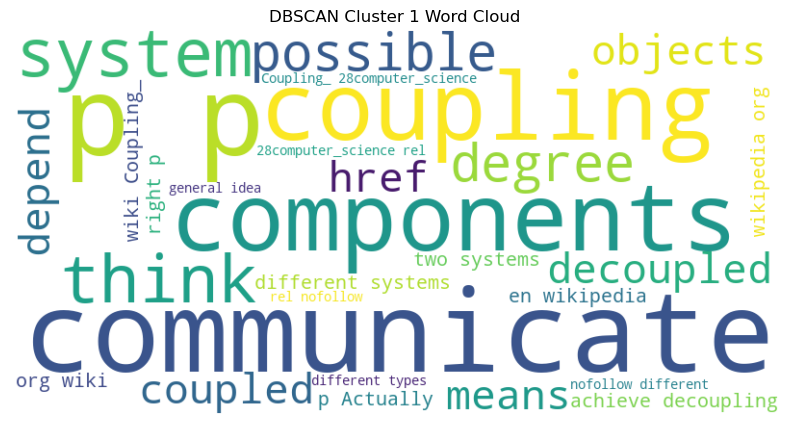

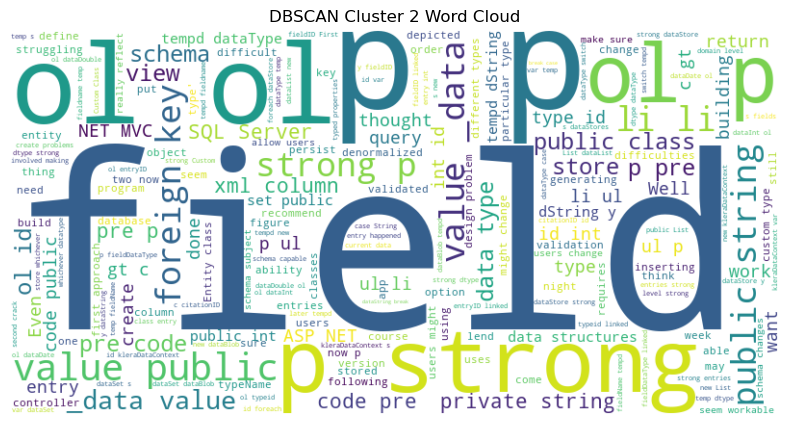

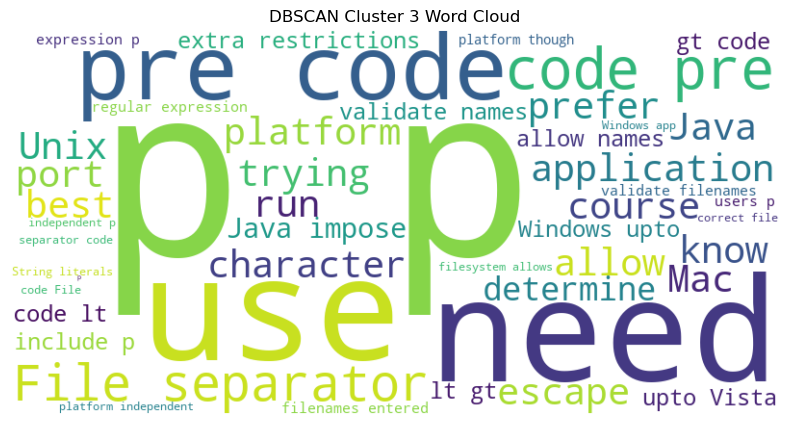

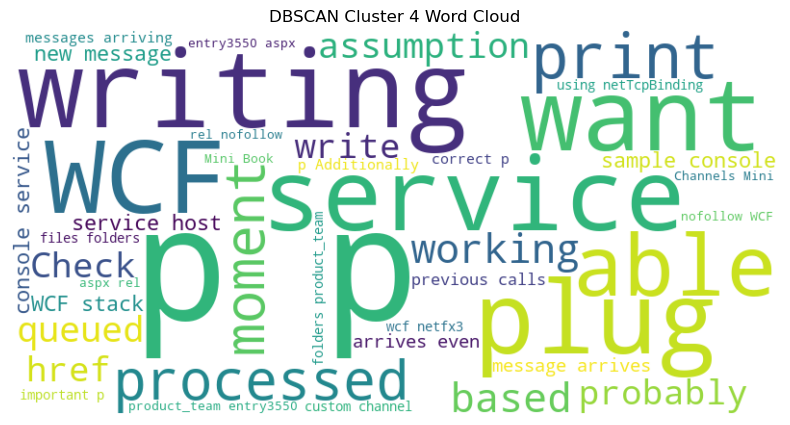

In [23]:
print("Generating Word Clouds for DBSCAN Clusters...")
unique_dbscan_labels = set(dbscan_labels) - {-1}  # Exclude noise points (-1)

if not unique_dbscan_labels:
    print("No valid clusters found for DBSCAN.")
else:
    max_clusters_to_print = 5  # Set the maximum number of clusters to print
    selected_clusters = sorted(unique_dbscan_labels)[:max_clusters_to_print]
    for cluster in selected_clusters:
        # Filter data for the current cluster
        cluster_data = final_data[dbscan_labels == cluster]
        
        # Combine text for the current cluster
        text = " ".join(cluster_data['Text'].dropna())
        
        # Check if the cluster has valid text
        if not text.strip():
            print(f"Cluster {cluster} has no valid text data.")
            continue

        # Generate Word Cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        # Plot the Word Cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"DBSCAN Cluster {cluster} Word Cloud")
        plt.show()

Running HDBSCAN clustering...
Visualizing clusters...


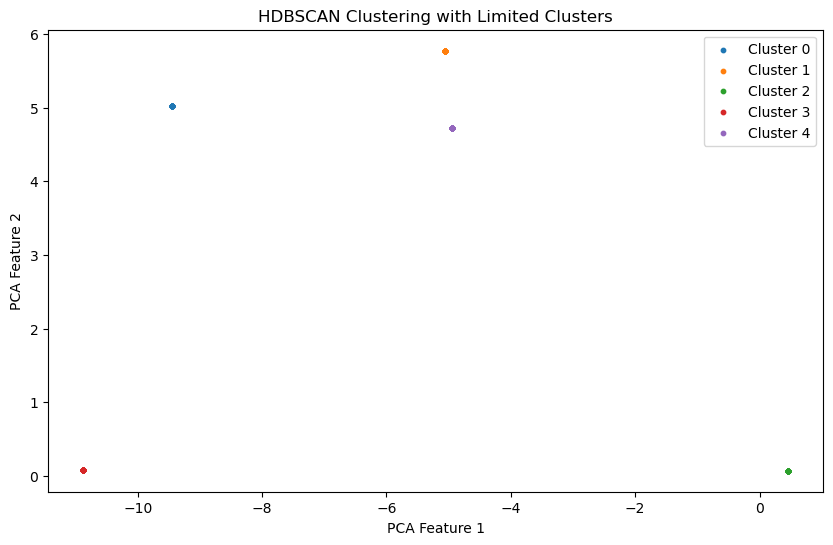

In [25]:
# Apply HDBSCAN clustering
print("Running HDBSCAN clustering...")
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
hdbscan_labels = clusterer.fit_predict(vectors)

# Limit clusters to 5 for visualization and analysis
limited_clusters = pd.Series(hdbscan_labels).replace(to_replace=list(set(hdbscan_labels) - set(range(5))), value=-1)
final_data['Limited_Clusters'] = limited_clusters

# Visualize HDBSCAN Clustering
print("Visualizing clusters...")
plt.figure(figsize=(10, 6))
for cluster in range(5):
    cluster_data = reduced_features[limited_clusters == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', s=10)

plt.title("HDBSCAN Clustering with Limited Clusters")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend()
plt.show()

Generating word clouds for clusters...


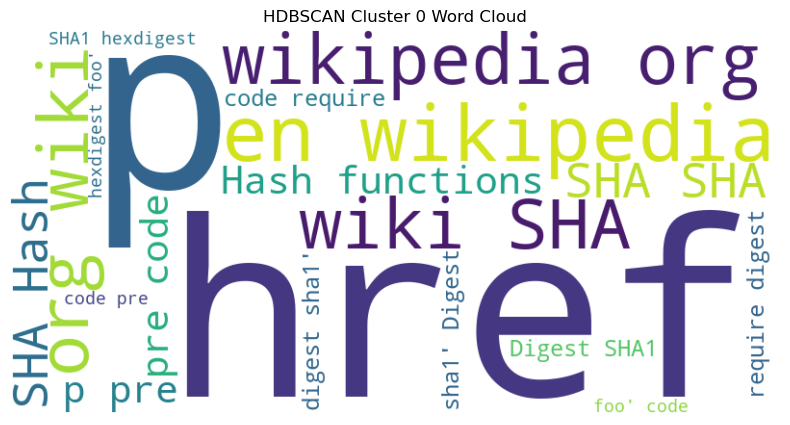

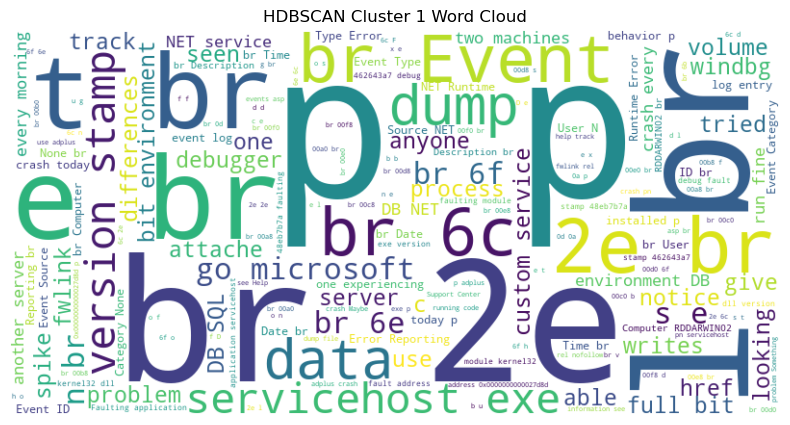

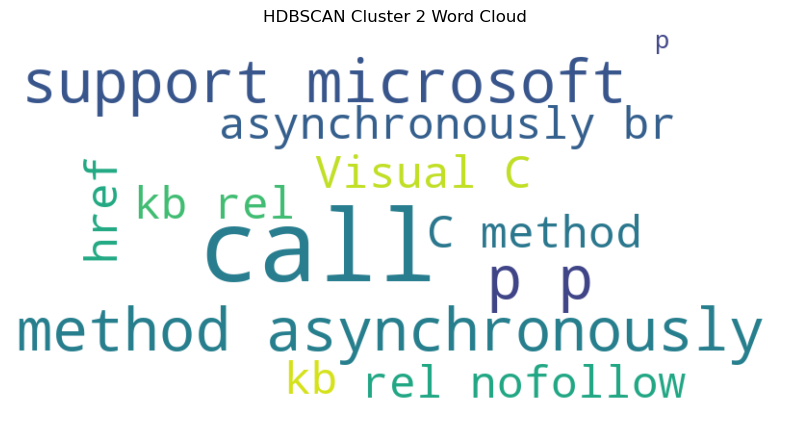

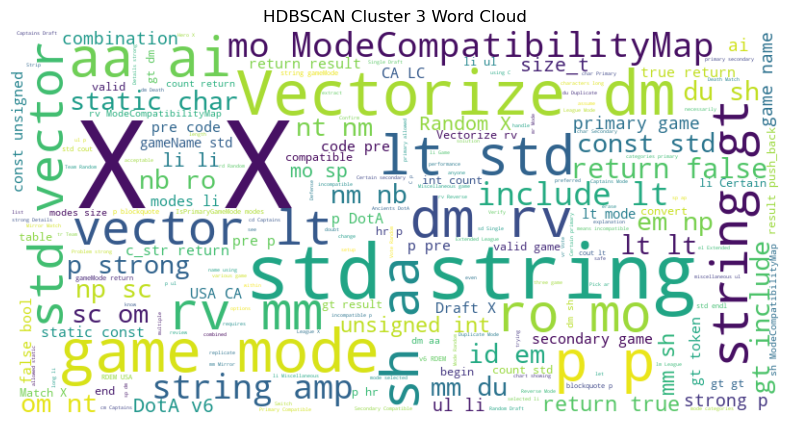

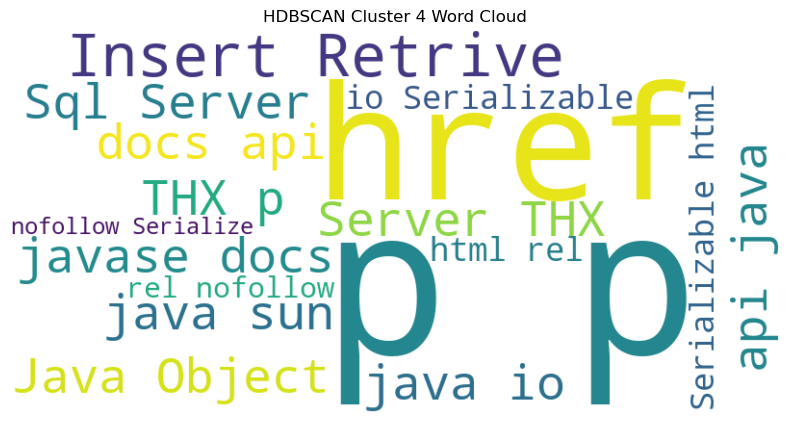

In [27]:
# Generate Word Clouds for Clusters
print("Generating word clouds for clusters...")
for cluster in range(5):
    cluster_data = final_data[final_data['Limited_Clusters'] == cluster]
    text = " ".join(cluster_data['Text'].dropna())
    
    if not text.strip():
        print(f"Cluster {cluster} has no valid text data.")
        continue
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"HDBSCAN Cluster {cluster} Word Cloud")
    plt.show()

### Meaning of Word Cloud for HDBSCAN

If we look at the wordcloud in cluster 1 we can see that words like lib, usr, gems, ruby are more prominent.
This suggests that this cluster us focused on disucssions of the Ruby Programming language.

### Terms:
actionpack, activerecord and mongreal all are ruby components


This cluster groups text data relevant to software development using Ruby, with a focus on packages, web frameworks, and templating.

Likely questions or discussions in this cluster could involve:
- How to manage gems in Ruby.
- Troubleshooting library paths (e.g., usr/lib).
- Configuring templating engines (e.g., xsl, erb).

### Save the model to pickle files to avoid over computation

In [31]:
# File paths for saving models and results
kmeans_model_path = '../models/kmeans_model.pkl'
kmeans_labels_path = '../models/kmeans_labels.pkl'

dbscan_model_path = '../models/dbscan_model.pkl'
dbscan_labels_path = '../models/dbscan_labels.pkl'

hdbscan_model_path = '../models/hdbscan_model.pkl'
hdbscan_labels_path = '../models/hdbscan_labels.pkl'

reduced_vectors_path = '../models/reduced_vectors.pkl'

# Save KMeans model and labels
print("Saving KMeans model and labels...")
with open(kmeans_model_path, 'wb') as file:
    pickle.dump(kmeans, file)
print(f"KMeans model saved to {kmeans_model_path}.")

with open(kmeans_labels_path, 'wb') as file:
    pickle.dump(kmeans_labels, file)
print(f"KMeans labels saved to {kmeans_labels_path}.")

# Save DBSCAN model and labels
print("Saving DBSCAN model and labels...")
with open(dbscan_model_path, 'wb') as file:
    pickle.dump(dbscan, file)
print(f"DBSCAN model saved to {dbscan_model_path}.")

with open(dbscan_labels_path, 'wb') as file:
    pickle.dump(dbscan_labels, file)
print(f"DBSCAN labels saved to {dbscan_labels_path}.")

# Save HDBSCAN model and labels
print("Saving HDBSCAN model and labels...")
with open(hdbscan_model_path, 'wb') as file:
    pickle.dump(clusterer, file)
print(f"HDBSCAN model saved to {hdbscan_model_path}.")

with open(hdbscan_labels_path, 'wb') as file:
    pickle.dump(hdbscan_labels, file)
print(f"HDBSCAN labels saved to {hdbscan_labels_path}.")

# Save PCA-reduced vectors for visualization
print("Saving PCA-reduced vectors...")
with open(reduced_vectors_path, 'wb') as file:
    pickle.dump(reduced_features, file)
print(f"PCA-reduced vectors saved to {reduced_vectors_path}.")

Saving KMeans model and labels...
KMeans model saved to ../models/kmeans_model.pkl.
KMeans labels saved to ../models/kmeans_labels.pkl.
Saving DBSCAN model and labels...
DBSCAN model saved to ../models/dbscan_model.pkl.
DBSCAN labels saved to ../models/dbscan_labels.pkl.
Saving HDBSCAN model and labels...
HDBSCAN model saved to ../models/hdbscan_model.pkl.
HDBSCAN labels saved to ../models/hdbscan_labels.pkl.
Saving PCA-reduced vectors...
PCA-reduced vectors saved to ../models/reduced_vectors.pkl.


### Metrics for the three clustering algorithms

In [34]:
def calculate_metrics(data, labels, method_name):
    print(f"\nMetrics for {method_name}:")
    unique_labels = set(labels)
    if len(unique_labels) > 1 and -1 not in unique_labels:  # Ensure more than 1 valid cluster
        silhouette = silhouette_score(data, labels)
        calinski_harabasz = calinski_harabasz_score(data, labels)
        davies_bouldin = davies_bouldin_score(data, labels)
        
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Index: {calinski_harabasz:.3f}")
        print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
    else:
        print("Not enough valid clusters for metrics computation.")
    cluster_counts = Counter(labels)
    print(f"Cluster Sizes: {dict(cluster_counts)}")

# Evaluate each clustering method
calculate_metrics(reduced_features, kmeans_labels, "KMeans")
calculate_metrics(reduced_features, dbscan_labels, "DBSCAN")
calculate_metrics(reduced_features, hdbscan_labels, "HDBSCAN")


Metrics for KMeans:
Silhouette Score: 0.339
Calinski-Harabasz Index: 191349.406
Davies-Bouldin Index: 0.942
Cluster Sizes: {2: 29538, 4: 58006, 3: 37161, 1: 43311, 0: 9626}

Metrics for DBSCAN:
Not enough valid clusters for metrics computation.
Cluster Sizes: {0: 20, 1: 10, -1: 18487, 2: 8, 3: 12, 4: 9, 5: 25, 6: 20, 7: 9, 8: 8, 9: 9, 10: 18, 11: 5, 12: 8, 13: 15, 14: 6, 15: 6, 16: 30, 17: 20, 18: 12, 19: 6, 20: 18, 21: 20, 22: 20, 23: 18, 24: 10, 25: 10, 26: 15, 27: 6, 28: 10, 29: 15, 30: 6, 31: 8, 32: 6, 33: 18, 34: 6, 35: 6, 36: 25, 37: 10, 38: 9, 39: 6, 40: 5, 41: 32, 42: 9, 43: 8, 44: 9, 45: 12, 46: 18, 47: 12, 48: 8, 49: 6, 50: 12, 51: 18, 52: 6, 53: 15, 54: 12, 55: 8, 56: 9, 57: 5, 58: 24, 59: 6, 60: 16, 61: 6, 62: 8, 63: 5, 64: 16, 65: 18, 66: 12, 67: 16, 68: 12, 69: 20, 70: 16, 71: 30, 72: 24, 73: 7, 74: 6, 75: 18, 76: 6, 77: 16, 78: 15, 79: 9, 80: 10, 81: 35, 82: 12, 83: 25, 84: 28, 85: 10, 86: 18, 87: 8, 88: 12, 89: 10, 90: 5, 91: 7, 92: 12, 93: 20, 94: 6, 95: 6, 96: 12, 97

It is evident from the above results that the KMeans clustering is the best clustering algorithms.

### This part of the code will use KMeans in order to cluster questions under tags and then get the quesitons related to tag into one place for easier access

In [51]:
# Dictionary to store the clustering results by tag

final_data['Tag'] = final_data['Tag'].fillna('Unknown')  # Handle missing tags

# Drop empty questions
final_data = final_data.dropna(subset=['QuestionText']).reset_index(drop=True)

# Directory for saving word clouds
WORDCLOUD_DIR = './static/wordclouds'
os.makedirs(WORDCLOUD_DIR, exist_ok=True)

# Dictionary to store clustering results by tag
tag_clusters = {}

# Vectorizer for TF-IDF with a custom tokenizer
vectorizer = TfidfVectorizer(max_features=1000, tokenizer=lambda x: re.findall(r'\b\w+\b', x.lower()), stop_words='english')

# Iterate through each tag
for tag in final_data['Tag'].unique():
    tag_questions = final_data[final_data['Tag'] == tag]['QuestionText']
    
    # Skip tags with insufficient data
    if len(tag_questions.dropna()) < 2:
        print(f"Skipping tag '{tag}' due to insufficient data.")
        continue

    try:
        # Transform questions to TF-IDF vectors
        tfidf_matrix = vectorizer.fit_transform(tag_questions)

        # Number of clusters for this tag
        num_clusters = min(len(tag_questions) // 5, 5)  # Adjust cluster count as needed
        num_clusters = max(2, num_clusters)  # Ensure at least 2 clusters

        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(tfidf_matrix)

        # Add clustering results to the dictionary
        tag_clusters[tag] = {
            'questions': tag_questions.tolist(),
            'clusters': cluster_labels.tolist(),
        }

        # Generate word clouds for each cluster
        for cluster in range(num_clusters):
            cluster_data = tag_questions[cluster_labels == cluster]
            text = " ".join(cluster_data.dropna())
            if not text.strip():
                continue

            wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
            image_path = f"{WORDCLOUD_DIR}/{tag}_cluster_{cluster}.png"
            wordcloud.to_file(image_path)

    except ValueError as e:
        print(f"Error processing tag '{tag}': {e}")
        continue

print("Clustering complete. Results saved.")

# Save clustering results for the app
with open('../models/tag_clusters.pkl', 'wb') as f:
    pickle.dump(tag_clusters, f)

C:\Users\pujaris\AppData\Local\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\pujaris\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Skipping tag 'svd' due to insufficient data.
Skipping tag 'eigenvector' due to insufficient data.
Skipping tag 'eigenvalue' due to insufficient data.
Skipping tag 'simbl' due to insufficient data.
Skipping tag 'dispatcher' due to insufficient data.
Skipping tag 'dial-up' due to insufficient data.
Skipping tag 'broadband' due to insufficient data.
Skipping tag 'rank' due to insufficient data.
Skipping tag 'pervasive' due to insufficient data.
Skipping tag 'listfield' due to insufficient data.
Skipping tag 'lapack' due to insufficient data.
Skipping tag 'custom-protocol' due to insufficient data.
Skipping tag 'stdafx.h' due to insufficient data.
Skipping tag 'labels' due to insufficient data.
Skipping tag 'display-picture' due to insufficient data.
Skipping tag 'hidden-field' due to insufficient data.
Skipping tag 'tablecelleditor' due to insufficient data.
Skipping tag 'typesetting' due to insufficient data.
Skipping tag 'xdebug' due to insufficient data.
Skipping tag 'yacc' due to insu